## Aid system for cancerigenous tissues

#### 0)  Upload histological images

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import io

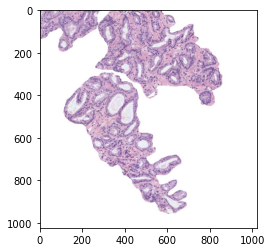

In [3]:
img = io.imread('images/histo_2.jpg')
img_norm = img/255
plt.imshow(img_norm)

#### 1)Perform a colour transformation to convert the image to the CMYK colour space.

In [5]:
with np.errstate(invalid='ignore', divide='ignore'):
    K = 1 - np.max(img_norm, axis=2)
    C = (1-img_norm[...,0] - K)/(1-K)
    M = (1-img_norm[...,1] - K)/(1-K)
    Y = (1-img_norm[...,2] - K)/(1-K)

CMYK = (np.dstack((C,M,Y,K)))
C,M,Y,K = cv2.split(CMYK)

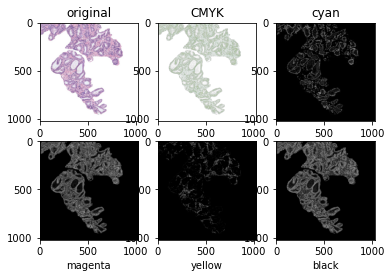

In [6]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(img_norm, cmap='gray'), ax[0,0].set_title('original')
ax[0,1].imshow(CMYK, cmap='gray'), ax[0,1].set_title('CMYK')
ax[0,2].imshow(C, cmap='gray'), ax[0,2].set_title('cyan')
ax[1,0].imshow(M, cmap='gray'), ax[1,0].set_xlabel('magenta')
ax[1,1].imshow(Y, cmap='gray'), ax[1,1].set_xlabel('yellow')
ax[1,2].imshow(K, cmap='gray'), ax[1,2].set_xlabel('black')
plt.show()

#### 2) Threshold the image to separate the background pixels from the tissue region.

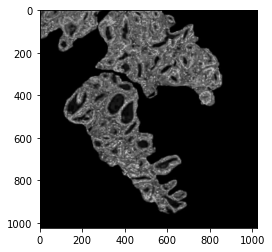

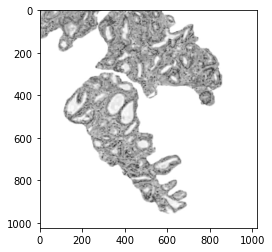

In [8]:
img_gaus = cv2.GaussianBlur(M, (5,5), 0)
plt.imshow(img_gaus, cmap='gray')
plt.show()
img_gaus_inv=1-img_gaus
plt.imshow(img_gaus_inv, cmap='gray')

[  0 255]


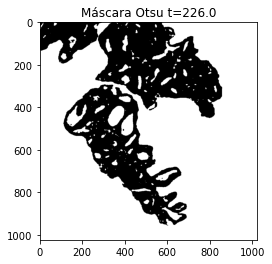

In [9]:
img_gaus=img_gaus_inv*255
t, mask = cv2.threshold(img_gaus.astype('uint8'),0,255,cv2.THRESH_OTSU) # 0 es por defecto y 1 es el valor máximo de la máscara
print(np.unique(mask))

# Visualizamos para corroborar que se obtiene el mismo resultado
plt.imshow(mask, cmap='gray')
plt.title('Máscara Otsu t=' + str(t))
plt.show()

#### 3) Clean up the image by removing lumen artefacts (small white objects that are not lumens).

In [11]:
from skimage import morphology

In [12]:
# Compute a mask
mask_2 = morphology.remove_small_holes(
    morphology.remove_small_objects(
        mask< 0.7, 300),
    300)


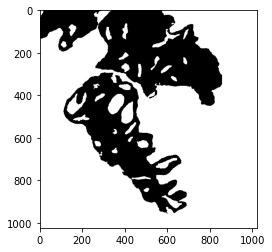

In [13]:
mask_2_inv= morphology.remove_small_objects(mask_2, 300, connectivity=1, in_place=False)
mask_2_inv=1-mask_2_inv
plt.imshow(mask_2_inv, cmap='gray')

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

In [14]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante. 

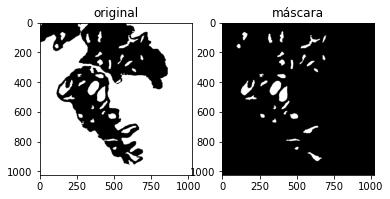

In [15]:
# Crear una copia de la imagen
mask_semilla = mask_2_inv.copy()

# Definir una imagen negra de referencia
h, w = mask_semilla.shape
ref = np.zeros((h+2, w+2), np.uint8)

# Fijar la semilla en la esquina superior izquierda
cv2.floodFill(mask_semilla, ref, (0,0), 0); 

# Fijar segunda semilla en la esquina superior inferior derecha
cv2.floodFill(mask_semilla, ref, (1024-1,1024-1), 0); 


fig, ax = plt.subplots(1,2)
ax[0].imshow(mask_2_inv, cmap='gray'), ax[0].set_title('original')
ax[1].imshow(mask_semilla, cmap='gray'), ax[1].set_title('máscara')
plt.show()

#### 5) Rellenar los objetos de los lúmenes

In [16]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante

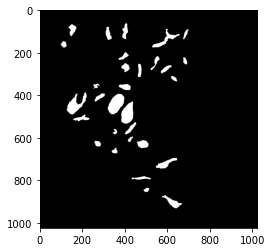

In [17]:
from scipy import ndimage
mask_fill_holes=ndimage.binary_fill_holes(mask_semilla)
plt.imshow(mask_fill_holes, cmap='gray')

In [18]:
#Desnormalizar la imagen y cambiarla a 'uint8'
copia_fill_holes=mask_fill_holes.copy()
img_seg_fill=np.where(copia_fill_holes==True, 1, 0)*255
img_seg_fill=img_seg_fill.astype('uint8')

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

In [19]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 
# Visualizar la imagen superpuesta

número de objetos:  30
posibles valores de intensidad:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]


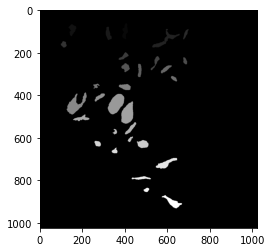

In [26]:
from skimage.measure import label

lab, num = label(img_seg_fill, return_num=True)

print('número de objetos: ', num)
v,c = np.unique(lab, return_counts=True)
print('posibles valores de intensidad: ', v)

plt.imshow(lab, cmap='gray')
plt.show()

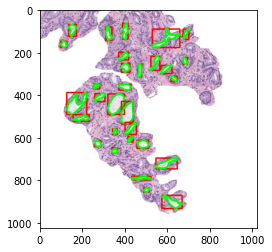

In [22]:
# Repetimos el proceso completo para todos los objetos de la imagen
from skimage.measure import regionprops
from skimage.morphology import convex_hull_image
imagen = img.copy()
for i in range(1, num+1): 
    objeto = lab == i
    objeto = objeto.astype('uint8')
    
    # bbox
    prop = regionprops(objeto)
    bbox = prop[0].bbox
    imagen = cv2.rectangle(imagen, (bbox[1], bbox[0]), (bbox[3], bbox[2]), (255, 0, 0), 5)
    
    # covex hull
    convex_image = convex_hull_image(objeto)
    convex_image = objeto.astype('uint8')
    _, conts, _ = cv2.findContours(convex_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    imagen = cv2.drawContours(imagen, conts, -1, (0,255,0), 8)

plt.imshow(imagen, cmap='gray')
plt.show()

#### 7) Identificar y cropear el lumen más grande

In [23]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

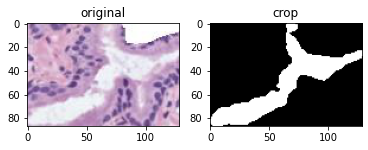

In [25]:
imagen_7 = img.copy()
my_list = []
for i in range(1, num+1): 
    objeto = lab == i
    objeto = objeto.astype('uint8')

    # bbox
    prop = regionprops(objeto)
    bbox = prop[0].bbox
    imagen_7 = cv2.rectangle(imagen_7, (bbox[1], bbox[0]), (bbox[3], bbox[2]), (255, 0, 0), 5)

    ancho = bbox[2] - bbox[0]
    alto = bbox[3] - bbox[1]
    
    my_list.append(ancho * alto) 
    
    index_max = max(range(len(my_list)), key=my_list.__getitem__)
    
    convex_image = convex_hull_image(objeto)
    convex_image = convex_image.astype('uint8')
    _, conts, _ = cv2.findContours(convex_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    imagen_7 = cv2.drawContours(imagen_7, conts, -1, (0,255,0), 8)


    resultado = lab == index_max+1
    resultado = resultado.astype('uint8')
        # bbox
    prop2 = regionprops(resultado)
    bbox2 = prop2[0].bbox
    
    cropped = img[bbox2[0]:bbox2[2],bbox2[1]:bbox2[3]]
    resultado = resultado[bbox2[0]:bbox2[2],bbox2[1]:bbox2[3]]

figs, ax = plt.subplots(1,2)
ax[0].imshow(cropped, cmap='gray'), ax[0].set_title('original')
ax[1].imshow(resultado, cmap='gray'), ax[1].set_title('crop')
plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [23]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

In [24]:
from tabulate import tabulate
import math

new_lab, new_num = label(resultado, return_num=True)

# Extraemos las característicias geométricas
headers=['Lumen']
A,BB,CA,E,ED,EX,F,MA,MiA,OR,P,S,CO= ['area'], ['bbox_area'], ['convex_area'], ['eccentricity'], ['equiv_diameter'], \
['extent'], ['feret'],['major_axis'], ['minor_axis'], ['orientation'], ['perimeter'], ['solidity'], ['compactness']

for i in range(1,new_num+1):
    objeto = new_lab == i
    prop = regionprops(objeto.astype(np.uint8))
    
    A.append(np.round(prop[0].area, 4))
    BB.append(np.round(prop[0].bbox_area, 4))
    CA.append(np.round(prop[0].convex_area, 4))
    E.append(np.round(prop[0].eccentricity, 4))
    ED.append(np.round(prop[0].equivalent_diameter, 4))
    EX.append(np.round(prop[0].extent, 4))
    F.append(np.round(prop[0].feret_diameter_max,4))
    MA.append(np.round(prop[0].major_axis_length, 4))
    MiA.append(np.round(prop[0].minor_axis_length, 4))
    OR.append(np.round(prop[0].orientation, 4))
    P.append(np.round(prop[0].perimeter, 4))
    S.append(np.round(prop[0].solidity, 4))
    CO.append(np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4))


my_data = [tuple(A), tuple(BB), tuple(CA), tuple(E), tuple(ED), tuple(EX), tuple(F),\
          tuple(MA), tuple(MiA), tuple(OR), tuple(P), tuple(S), tuple(CO)]

In [25]:
print(tabulate(my_data, headers=headers))

                     Lumen
--------------  ----------
area             2431
bbox_area       11223
convex_area      5169
eccentricity        0.948
equiv_diameter     55.6349
extent              0.2166
feret             142.696
major_axis        143.719
minor_axis         45.7279
orientation        -0.9877
perimeter         407.505
solidity            0.4703
compactness         0.184
